In [1]:
import torch
import torchvision

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


def cv_imshow(img):
    im = img[:,:,::-1]
    fig_h = 12
    plt.figure(figsize=(fig_h, int(1.0 * fig_h * im.shape[0] / im.shape[1])))
    plt.axis('off')
    plt.imshow(im, aspect='auto')

# https://github.com/facebookresearch/detectron2
DETECTRON2_REPO_PATH = './detectron2/'

In [2]:
# register the traffic light dataset
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
from tl_dataset import parse_label_file


def get_tl_dicts(data_dir):
    dataset_dicts = []
    list_filepath = os.path.abspath(os.path.join(data_dir, 'list'))
    with open(list_filepath, 'r') as f:
        for line in f.readlines():
            fields = line.strip().split()
            image_path = os.path.abspath(os.path.join(data_dir, fields[0]))
            label_path = os.path.abspath(os.path.join(data_dir, fields[1]))
            image_label = {'path': image_path, 'boxes': []}
            image_label['boxes'] = parse_label_file(label_path)

            record = {}
            height, width = cv2.imread(image_path).shape[:2]
            record["file_name"] = image_path
            record["height"] = height
            record["width"] = width
            objs = []
            for box in image_label['boxes']:
                obj = {
                    "bbox": [box['xmin'], box['ymin'], box['xmax'], box['ymax']],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": 0,
                    "iscrowd": 0
                }
                objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["trainsets", "testsets"]:
    DatasetCatalog.register("apollo_tl_demo_data/" + d, lambda d=d: get_tl_dicts("apollo_tl_demo_data/" + d))
    MetadataCatalog.get("apollo_tl_demo_data/" + d).set(thing_classes=["traffic_light"])
tl_metadata = MetadataCatalog.get("apollo_tl_demo_data/trainsets")

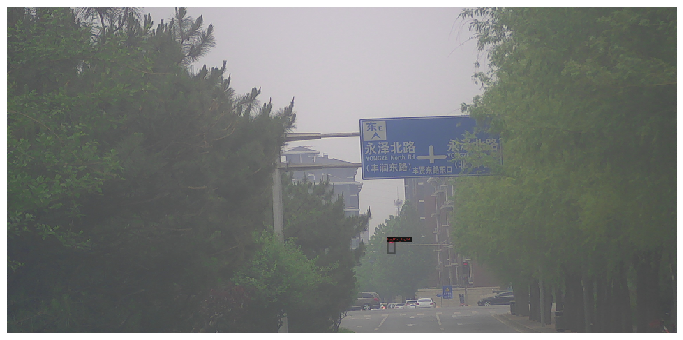

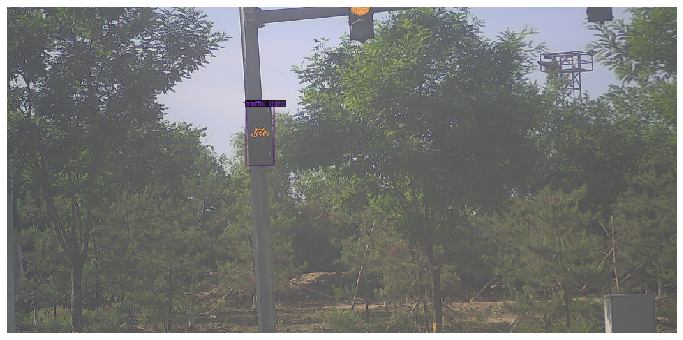

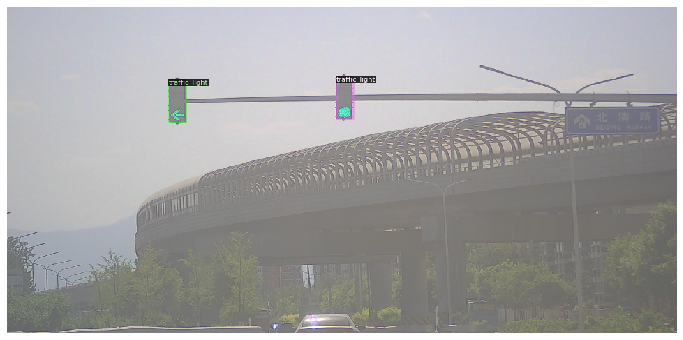

In [3]:
# show samples from dataset
import random

dataset_dicts = get_tl_dicts("apollo_tl_demo_data/trainsets")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=tl_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv_imshow(vis.get_image()[:, :, ::-1])

In [4]:
# Train
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(DETECTRON2_REPO_PATH + "./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("apollo_tl_demo_data/trainsets",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
# initialize from model zoo
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (traffic light)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [11/03 11:23:21 d2.config.compat]: Config './detectron2/./configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[11/03 11:23:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1):

[11/03 11:23:26 d2.data.build]: Removed 0 images with no usable annotations. 100 images left.
[11/03 11:23:26 d2.data.build]: Distribution of training instances among all 1 categories:
|   category    | #instances   |
|:-------------:|:-------------|
| traffic_light | 217          |
|               |              |
[11/03 11:23:26 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/03 11:23:26 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


[11/03 11:23:27 d2.engine.train_loop]: Starting training from iteration 0
[11/03 11:23:36 d2.utils.events]: eta: 0:02:18  iter: 19  total_loss: 1.103  loss_cls: 0.549  loss_box_reg: 0.520  loss_rpn_cls: 0.032  loss_rpn_loc: 0.012  time: 0.4855  data_time: 0.0027  lr: 0.000200  max_mem: 2641M
[11/03 11:23:46 d2.utils.events]: eta: 0:02:07  iter: 39  total_loss: 0.585  loss_cls: 0.189  loss_box_reg: 0.392  loss_rpn_cls: 0.026  loss_rpn_loc: 0.011  time: 0.4852  data_time: 0.0016  lr: 0.000400  max_mem: 2641M
[11/03 11:23:56 d2.utils.events]: eta: 0:01:58  iter: 59  total_loss: 0.578  loss_cls: 0.107  loss_box_reg: 0.466  loss_rpn_cls: 0.019  loss_rpn_loc: 0.015  time: 0.4881  data_time: 0.0016  lr: 0.000599  max_mem: 2641M
[11/03 11:24:06 d2.utils.events]: eta: 0:01:48  iter: 79  total_loss: 0.529  loss_cls: 0.078  loss_box_reg: 0.415  loss_rpn_cls: 0.010  loss_rpn_loc: 0.013  time: 0.4935  data_time: 0.0017  lr: 0.000799  max_mem: 2641M
[11/03 11:24:16 d2.utils.events]: eta: 0:01:40  it

OrderedDict()

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("apollo_tl_demo_data/testsets", )
predictor = DefaultPredictor(cfg)

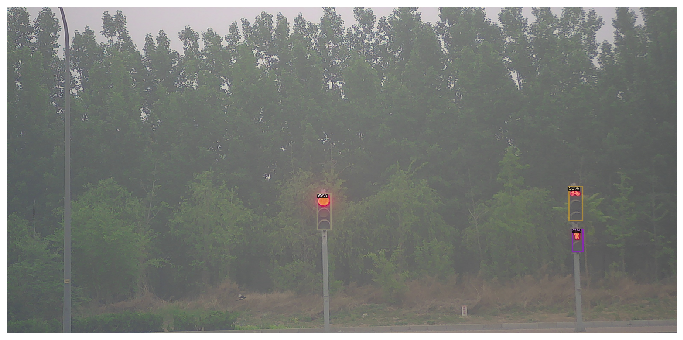

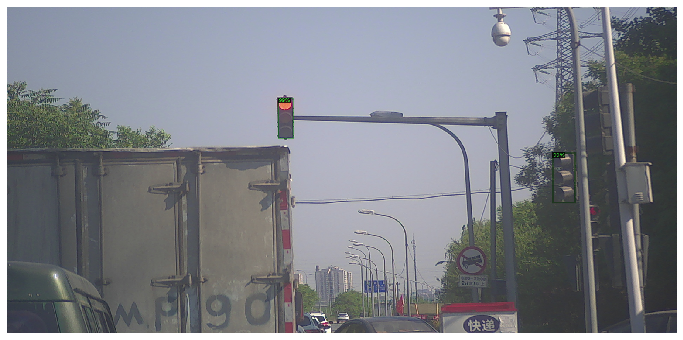

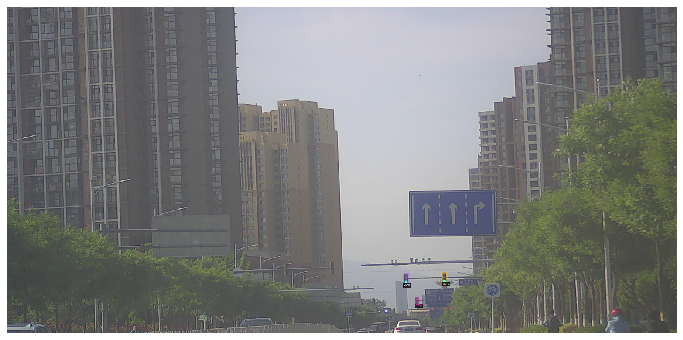

In [6]:
from detectron2.utils.visualizer import ColorMode

# testsets contains no label
# dataset_dicts = get_tl_dicts("apollo_tl_demo_data/testsets")
dataset_dicts = get_tl_dicts("apollo_tl_demo_data/trainsets")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=tl_metadata, 
                   scale=0.8,
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv_imshow(v.get_image()[:, :, ::-1])